In [25]:
# Install/upgrade packages if needed (Colab usually has TF preinstalled)
!pip install -q --upgrade pip
!pip install -q tensorflow numpy matplotlib scikit-learn pillow
import tensorflow as tf
print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.19.0


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [27]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)


Train shape: (50000, 32, 32, 3) Test shape: (10000, 32, 32, 3)


In [28]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)


Train shape: (50000, 32, 32, 3) Test shape: (10000, 32, 32, 3)


In [29]:
def build_model(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
EPOCHS = 10
BATCH = 64

checkpoint_cb = callbacks.ModelCheckpoint('model_colab.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,)

history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=BATCH),
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test_cat),
                    steps_per_epoch=len(x_train)//BATCH,
                    callbacks=[checkpoint_cb, reduce_lr])


Epoch 1/10
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3204 - loss: 1.8292

781/781 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.3206 - loss: 1.8286 - val_accuracy: 0.5375 - val_loss: 1.2548 - learning_rate: 0.0010
Epoch 2/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4375 - loss: 1.4084

781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 1.4084 - val_accuracy: 0.5398 - val_loss: 1.2545 - learning_rate: 0.0010
Epoch 3/10
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5213 - loss: 1.3347

781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5213 - loss: 1.3345 - val_accuracy: 0.6398 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 1.0785 - val_accuracy: 0.6281 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 5/10
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5910 - loss: 1.1469

781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5910 - loss: 1.1468 - val_accuracy: 0.6802 - val_loss: 0.8978 - learning_rate: 0.0010
Epoch 6/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5938 - loss: 1.1407

781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 1.1407 - val_accuracy: 0.6843 - val_loss: 0.8951 - learning_rate: 0.0010
Epoch 7/10
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6284 - loss: 1.0510

781/781 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6284 - loss: 1.0509 - val_accuracy: 0.7009 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 8/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7031 - loss: 0.9457 - val_accuracy: 0.6981 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 9/10
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6573 - loss: 0.9755

781/781 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.6573 - loss: 0.9755 - val_accuracy: 0.7079 - val_loss: 0.8341 - learning_rate: 0.0010
Epoch 10/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6406 - loss: 0.9158

781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6406 - loss: 0.9158 - val_accuracy: 0.7097 - val_loss: 0.8222 - learning_rate: 0.0010


Text(0.5, 1.0, 'Loss')

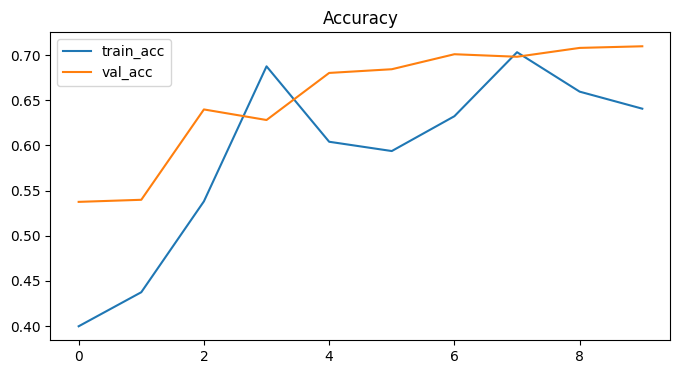

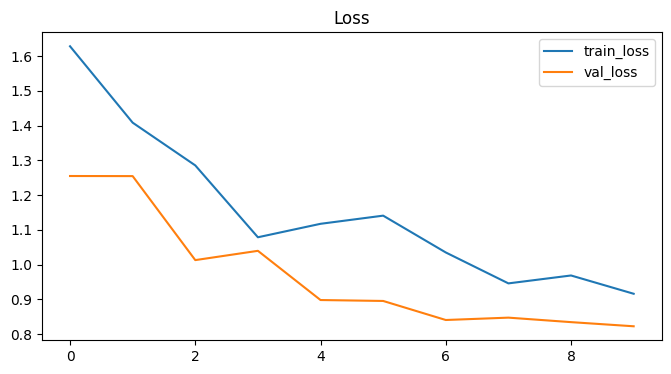

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0     0.7456    0.7680    0.7567      1000
           1     0.8256    0.8570    0.8410      1000
           2     0.7299    0.4620    0.5658      1000
           3     0.5965    0.4420    0.5078      1000
           4     0.7221    0.5250    0.6080      1000
           5     0.6476    0.6010    0.6234      1000
           6     0.6597    0.8550    0.7448      1000
           7     0.6563    0.8480    0.7400      1000
           8     0.8443    0.8190    0.8315      1000
           9     0.6840    0.9200    0.7846      1000

    accuracy                         0.7097     10000
   macro avg     0.7112    0.7097    0.7004     10000
weighted avg     0.7112    0.7097    0.7004     10000



Text(70.72222222222221, 0.5, 'True')

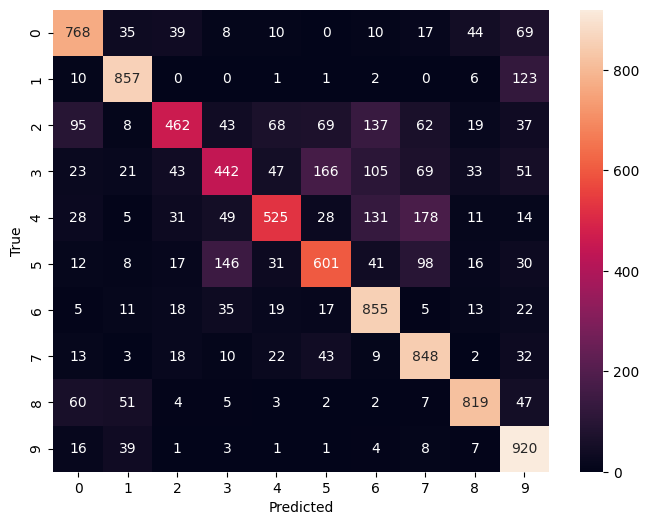

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
best = models.load_model('model_colab.h5')
preds = best.predict(x_test)
y_pred = preds.argmax(axis=1)
y_true = y_test.flatten()
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted'); plt.ylabel('True')


In [33]:
# Uncomment and run if you want to save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
best.save('/content/drive/MyDrive/aiml_cifar10_model.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import os

CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
MODEL_PATH = "/content/model_colab.h5"   # <- your model path

best = None
def load_model_if_needed(model_path=MODEL_PATH):
    global best
    if best is None:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at: {model_path}")
        print("Loading model from:", model_path)
        best = load_model(model_path)
    return best

def predict_image(path, model_path=MODEL_PATH, verbose=True):
    try:
        model = load_model_if_needed(model_path)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Image file not found at: {path}")

        img = Image.open(path).convert('RGB').resize((32,32))
        arr = np.array(img).astype('float32') / 255.0
        if arr.shape != (32,32,3):
            raise ValueError(f"Unexpected image shape after resize: {arr.shape}")
        arr = np.expand_dims(arr, axis=0)

        if verbose:
            print("Image loaded. array shape:", arr.shape, "dtype:", arr.dtype)

        preds = model.predict(arr)
        probs = preds[0]
        idx = int(np.argmax(probs))
        class_name = CLASS_NAMES[idx]
        confidence = float(probs[idx])

        if verbose:
            print('Predicted:', class_name, '- confidence:', round(confidence, 4))
        return class_name, confidence

    except Exception as e:
        print("Error in predict_image:", str(e))
        raise


In [35]:
# Upload image via Colab UI
from google.colab import files
uploaded = files.upload()   # use the file chooser that appears
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

# Predict using the uploaded image
predict_image(image_path, model_path="/content/model_colab.h5")


Saving download (1).jpeg to download (1) (2).jpeg
Uploaded: download (1) (2).jpeg
Loading model from: /content/model_colab.h5
Image loaded. array shape: (1, 32, 32, 3) dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Predicted: dog - confidence: 0.7156


('dog', 0.7156339883804321)

In [39]:
# Upload image via Colab UI
from google.colab import files
uploaded = files.upload()   # use the file chooser that appears
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

# Predict using the uploaded image
predict_image(image_path, model_path="/content/model_colab.h5")

Saving images (1).webp to images (1).webp
Uploaded: images (1).webp
Image loaded. array shape: (1, 32, 32, 3) dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: horse - confidence: 0.9948


('horse', 0.9947867393493652)

In [43]:
# Upload image via Colab UI
from google.colab import files
uploaded = files.upload()   # use the file chooser that appears
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

# Predict using the uploaded image
predict_image(image_path, model_path="/content/model_colab.h5")


Saving download (3).jpeg to download (3).jpeg
Uploaded: download (3).jpeg
Image loaded. array shape: (1, 32, 32, 3) dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: bird - confidence: 0.8231


('bird', 0.8230528831481934)

In [42]:
# Upload image via Colab UI
from google.colab import files
uploaded = files.upload()   # use the file chooser that appears
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

# Predict using the uploaded image
predict_image(image_path, model_path="/content/model_colab.h5")


Saving download (2).jpeg to download (2).jpeg
Uploaded: download (2).jpeg
Image loaded. array shape: (1, 32, 32, 3) dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: ship - confidence: 0.9953


('ship', 0.9953282475471497)